# Import Required Library

In [1]:
import numpy as np
import pandas as pd

# Regex
import re 

# Fix Contractions
import contractions

# Train Test Split
from sklearn.model_selection import train_test_split

# Deep Learning
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding

# Model Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Read Data

Data are collected from the [Analytic Vidhya, JanataHack: NLP Hackathon](https://www.kaggle.com/piyushagni5/sentiment-analysis-for-steam-reviews). The dataset consists of 5 columns and around 17,400 observations.

In [2]:
df = pd.read_csv("data/steam_review.csv")

df.head()

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1


# Text Preprocessing
## Text Cleansing

The text cleansing process including:

- Make text lowercase
- Remove mention name
- Remove the phrase `early access review`
- Remove url link
- Remove hashtag
- Remove html tag
- Remove contracted words
- Remove numbers
- Replace `?` into explicit quetionmark
- Replace `!` into explicit exclamationmark
- Remove everything except words and space
- Remove unnecessary white space

In [3]:
df_clean = df.copy()
# Make all text lowercase and remove mention
df_clean['user_review'] = list(map(lambda x: re.sub("\\@.*? |\\@.*?[!'#S%&'()*+,-./:;<=>?@[/]^_{|}~]|\\@.*", " ", x.lower()), df_clean['user_review']))
# Remove the phrase "early access review"
df_clean['user_review'] = list(map(lambda x: re.sub("early access review", " ", x), df_clean['user_review']))
# Remove url
df_clean['user_review'] = list(map(lambda x: re.sub("http.*? |http.*?[!'#S%&'()*+,-./:;<=>?@[/]^_{|}~]|http.*", " ", x), df_clean['user_review']))
# Remove hashtag
df_clean['user_review'] = list(map(lambda x: re.sub("#.*? |#.*?[!'#S%&'()*+,-./:;<=>?@[/]^_{|}~]|#.*", " ", x), df_clean['user_review']))
# Remove html tag
df_clean['user_review'] = list(map(lambda x: re.sub("<.*?>", " ", x), df_clean['user_review']))
# Replace contracted word
df_clean['user_review'] = list(map(lambda x: contractions.fix(x), df_clean['user_review']))
# Remove numbers
df_clean['user_review'] = list(map(lambda x: re.sub("[0-9]", " ", x), df_clean['user_review']))
# Replace "?" with questionmark
df_clean['user_review'] = list(map(lambda x: re.sub("[?]", " questionmark", x), df_clean['user_review']))
# Replace "!" with exclamationmark
df_clean['user_review'] = list(map(lambda x: re.sub("[!]", " exclamationmark", x), df_clean['user_review']))
# Remove everything except words and space
df_clean['user_review'] = list(map(lambda x: re.sub("'s", " ", x), df_clean['user_review']))
df_clean['user_review'] = list(map(lambda x: re.sub("[^\w\s]", " ", x), df_clean['user_review']))
# Remove unnecessary white space
df_clean['user_review'] = list(map(lambda x: re.sub(" +", " ", x.strip()), df_clean['user_review']))

df_clean.head()

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I am scared and hearing creepy voices so I wil...,1
1,2,Spooky's Jump Scare Mansion,2016.0,best game more better than sam pepper youtube ...,1
2,3,Spooky's Jump Scare Mansion,2016.0,a littly iffy on the controls but once you kno...,1
3,4,Spooky's Jump Scare Mansion,2015.0,great game fun and colorful and all that a sid...,1
4,5,Spooky's Jump Scare Mansion,2015.0,not many games have the cute tag right next to...,1


## Word Count

Next, we need to check the length of the sentence on each review after being cleansed. Some text may only contain 1 or 2 words left after being cleansed so they are not very informative.

In [4]:
word_count = pd.Series(list(map(lambda x: len(x.split(" ")), df_clean['user_review'])))

word_count.describe()

count    17494.000000
mean       141.311993
std        165.399271
min          1.000000
25%         51.000000
50%         84.000000
75%        159.000000
max       1601.000000
dtype: float64

We will filter the dataset and will only use texts that at least has 3 words in the sentence. The choice of the minimum number of words is arbitrary.

In [5]:
df_clean = df_clean.loc[word_count > 3]
df_clean

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I am scared and hearing creepy voices so I wil...,1
1,2,Spooky's Jump Scare Mansion,2016.0,best game more better than sam pepper youtube ...,1
2,3,Spooky's Jump Scare Mansion,2016.0,a littly iffy on the controls but once you kno...,1
3,4,Spooky's Jump Scare Mansion,2015.0,great game fun and colorful and all that a sid...,1
4,5,Spooky's Jump Scare Mansion,2015.0,not many games have the cute tag right next to...,1
...,...,...,...,...,...
17489,25535,EverQuest II,2012.0,arguably the single greatest mmorp that exists...,1
17490,25536,EverQuest II,2017.0,an older game to be sure but has its own charm...,1
17491,25537,EverQuest II,2011.0,when i frist started playing everquest it was ...,1
17492,25538,EverQuest II,NaN,cool game the only thing that really pisses me...,1


# Train-Test Split

This step is where we will split our data into 2 separate dataset: training dataset and testing dataset.

- `Training Dataset`: Dataset that will be used to train the machine learning model
- `Testing Dataset`: Dataset that will be used to evaluate the performance of the model and check if the model can predict new unseen data.


In [6]:
x_train, x_test, y_train, y_test = train_test_split(df_clean["user_review"], df_clean["user_suggestion"], test_size = 0.2, random_state = 123)

print("Number of Train Data:", len(x_train))
print("Number of Train Data:", len(x_test))

Number of Train Data: 13964
Number of Train Data: 3491


# Further Text Preprocessing

We will check how many unique words that we have in our corpus/collection of texts in data train. This will help us determine how many words that we will use for the vocabulary of the input data.

In [7]:
text_review = 'a'
for i in range(len(x_train)):
    text_review = text_review + x_train.iloc[i]

len(set(text_review.split()))

53557

## Tokenization

We will transform the text data into token using tokenizer from keras library. This process is called tokenization because each sentence will broken down into words/terms.

In [8]:
num_words = 40000

tokenizer = Tokenizer(num_words = num_words, split = ' ')
tokenizer.fit_on_texts(x_train)

In [9]:
x_train_token = tokenizer.texts_to_sequences(x_train)
x_test_token = tokenizer.texts_to_sequences(x_test)

In [10]:
maxlen = 250

x_train_token = pad_sequences(x_train_token, maxlen = maxlen, padding='pre', truncating='post')
x_test_token = pad_sequences(x_test_token, maxlen = maxlen, padding='pre', truncating='post')

# Model Architecture

The model will use embedding layer as the input layer. In a variety of deep learning frameworks such as Keras, the embedding layer aims to train text data into numerical vectors which represent the closeness of the meaning of each word. The context and feature of the text will be extracted using the recurrent network of LSTM layer. To avoid overfitting, we will use the Elastic Net regularizer that use both L1 and L2 norm to penalize the loss function. The regularizer will help enforce the training process to steer towards relatively “simple” weights, which may make your model more generic and thus scalable.

In [11]:
tf.random.set_seed(123)

model = Sequential()

model.add(Embedding(input_dim = num_words, input_length = maxlen, output_dim = 8))
model.add(LSTM(units = 8, kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.1, l2=0.1),return_sequences=False))
model.add(Dense(units = 1, activation = "sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 8)            320000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 544       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 320,553
Trainable params: 320,553
Non-trainable params: 0
_________________________________________________________________


# Model Fitting

Since the model will be trained to classify between 2 classes, we will use the binary cross-entropy as the loss function. To update our model and minimize the loss function, we use the adam optimizer with learning rate of 0.001. The model trained with 9 epoch and the model will be updated every 64 observations, which we call as the batch size. We will also use 10% of the training dataset as the validation dataset to monitor if the model will go overfit after some time.

In [12]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=['acc'])

epochs = 10
batch_size = 64

# history = model.fit(x_train_token, y_train, epochs = epochs, batch_size = batch_size, validation_split = 0.1, verbose = 1)
# df_history = pd.DataFrame(history.history).reset_index()

In [13]:
model = tf.keras.models.load_model("output/python_model.hdf5")

df_history = pd.read_csv("output/python_history.csv")

Text(0, 0.5, 'Loss')

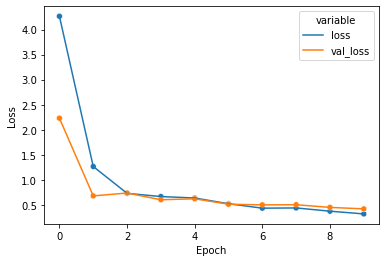

In [14]:

df_loss = df_history[['index', 'loss', 'val_loss']].melt(id_vars = ['index'])

sns.lineplot('index','value', data = df_loss, hue = 'variable')
sns.scatterplot('index','value', data = df_loss, hue = 'variable', legend = False)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

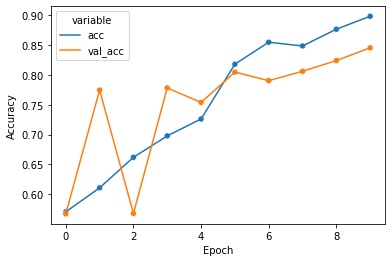

In [15]:
df_acc = df_history[['index', 'acc', 'val_acc']].melt(id_vars = ['index'])

sns.lineplot('index','value', data = df_acc, hue = 'variable')
sns.scatterplot('index','value', data = df_acc, hue = 'variable', legend = False)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Model Evaluation

Now we will predict the data test using the trained deep learning model.



In [16]:
pred_test = model.predict_classes(x_test_token)

pred_test[0:5]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[0],
       [0],
       [1],
       [1],
       [1]], dtype=int32)

## Confusion Matrix

In [17]:
confusion_matrix(y_test, pred_test)

array([[1201,  319],
       [ 243, 1728]])

## Model Performance

In [18]:
print("Accuracy: %.3f" %accuracy_score(y_test, pred_test))
print("Recall: %.3f" %recall_score(y_test, pred_test))
print("Precision: %.3f" %precision_score(y_test, pred_test))
print("F1 Score: %.3f" %f1_score(y_test, pred_test))

Accuracy: 0.839
Recall: 0.877
Precision: 0.844
F1 Score: 0.860
